In [1]:
from torch import nn, optim
import os
import shapely
import pandas as pd
import geopandas as gpd
import numpy as np
from numpy.random import default_rng
import torch
from sklearn.metrics import recall_score, precision_score, accuracy_score, f1_score, roc_auc_score
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
import libpysal
import matplotlib.pyplot as plt
from copy import deepcopy
from sklearn.cluster import KMeans
from collections import Counter

In [2]:
def load_data(year):
    os.getcwd()
    df = pd.DataFrame()
    path = "../Data/filled/" + str(year) + "/"
    for filename in os.listdir(path):
        print(filename)
        df1 = pd.read_csv(path + filename)
        if df1.geometry.isna().any():
            print(filename)
        df = pd.concat([df, df1])
    df = gpd.GeoDataFrame(df)
    df.geometry = df.geometry.apply(shapely.wkt.loads)
    
    df = df.reset_index()
    df = df.drop(["Unnamed: 0", "index"], axis = 1)
    return df

In [3]:
import torch
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = "cpu"
print("Device: {}".format(device))

Device: cpu


In [4]:
df15 = load_data(2015).set_index("C28992R100")
df16 = load_data(2016).set_index("C28992R100")
df17 = load_data(2017).set_index("C28992R100")
df18 = load_data(2018).set_index("C28992R100")
df19 = load_data(2019).set_index("C28992R100")


's-Gravenhage15.csv_filled_.csv
's-Gravenhage16.csv_filled_.csv
's-Gravenhage17.csv_filled_.csv
's-Gravenhage18.csv_filled_.csv
's-Gravenhage19.csv_filled_.csv


In [5]:
# Get data that is available in all years
overlapping1517 = df17.index[df17.index.isin(df16.index[df16.index.isin(df15.index)])]
overlapping1518 = df18.index[df18.index.isin(overlapping1517)]
overlapping1519 = df19.index[df19.index.isin(overlapping1518)]

# Fill X and Y
X = np.zeros((len(overlapping1519), 5, 40))
Y = np.zeros((len(overlapping1519), 5))
Y_1 = np.zeros((len(overlapping1519), 5))
ss = StandardScaler()

for i, df in enumerate([df15, df16, df17, df18, df19]):
    X[:,i] = df[df.columns[:-3]].loc[overlapping1519]
    Y[:,i] = df.loc[overlapping1519]["y"]
    Y_1[:,i] = df.loc[overlapping1519]["y-1"]


In [6]:
# Create neighbor lists for all years

df15 = df15.loc[overlapping1519]
df16 = df16.loc[overlapping1519]
df17 = df17.loc[overlapping1519]
df18 = df18.loc[overlapping1519]
df19 = df19.loc[overlapping1519]


w15 = libpysal.weights.DistanceBand.from_dataframe(df15.reset_index(), threshold=150, binary = True, silence_warnings = True)
w16 = libpysal.weights.DistanceBand.from_dataframe(df16.reset_index(), threshold=150, binary = True, silence_warnings = True)
w17 = libpysal.weights.DistanceBand.from_dataframe(df17.reset_index(), threshold=150, binary = True, silence_warnings = True)
w18 = libpysal.weights.DistanceBand.from_dataframe(df18.reset_index(), threshold=150, binary = True, silence_warnings = True)
w19 = libpysal.weights.DistanceBand.from_dataframe(df19.reset_index(), threshold=150, binary = True, silence_warnings = True)

In [7]:
c = 3

cluster_train = df17[df17.columns[:-5]]
cluster_val = df18[df18.columns[:-5]]
cluster_test = df19[df19.columns[:-5]]

cluster_train = ss.fit_transform(cluster_train)
cluster_val = ss.transform(cluster_val)
cluster_test = ss.transform(cluster_test)

cluster_model = KMeans(n_clusters =c, random_state = 1)
train_labels = pd.DataFrame(cluster_model.fit_predict(cluster_train))
val_labels = pd.DataFrame(cluster_model.predict(cluster_val))
test_labels = pd.DataFrame(cluster_model.predict(cluster_test))

In [8]:
print(Counter(train_labels[0]), Counter(val_labels[0]), Counter(test_labels[0]))

Counter({2: 4776, 1: 2784, 0: 1188}) Counter({2: 4714, 1: 2812, 0: 1222}) Counter({2: 4792, 1: 2807, 0: 1149})


In [9]:
# create Y(t-1) for all years

def get_y_1(y1, w):
    neighbors = [w.neighbors[x] for x in w.neighbors]
    y1 = np.array([y1[x].sum() for x in neighbors])
    y1[np.where(y1 == 0)[0]] = 0.5

    return y1

Y1_15 = get_y_1(Y_1[:,0], w15)
Y1_16 = get_y_1(Y_1[:,1], w16)
Y1_17 = get_y_1(Y_1[:,2], w17)
Y1_18 = get_y_1(Y_1[:,3], w18)
Y1_19 = get_y_1(Y_1[:,4], w19)



In [10]:
rng = default_rng()
def get_batch(X, Y, Y1, batch_size = 32):
    idxs = rng.integers(len(X), size = batch_size)
    return X[idxs], Y[idxs], Y1[idxs]



In [11]:
# X train is the first three years
X_train = X[:,:3]
X_train = np.delete(X_train, -1, 2)
Y_train = Y[:,2]

X_train = X_train.reshape(-1, 39)

# Fit and transform the standard scaler
X_train = ss.fit_transform(X_train)
X_train = X_train.reshape(-1,3,39)

Y1_18 = torch.tensor(Y1_18).float().to(device).to(device)
Y1s = np.vstack((Y1_15, Y1_16, Y1_17)).transpose().reshape(-1, 3, 1)
X_train = np.concatenate((X_train, Y1s), axis = 2)

In [12]:
print(X_train.shape)

(8748, 3, 40)


In [13]:
# create X_val and X_test
X_val = X[:,:4]
Y_val = Y[:,3]
X_val = np.delete(X_val, -1, 2)

X_val = X_val.reshape(-1, 39)
X_val = ss.transform(X_val)
X_val = X_val.reshape(-1, 4, 39)



X_test = X[:,:5]
Y_test = Y[:,4]
X_test = np.delete(X_test, -1, 2)
X_test = X_test.reshape(-1, 39)

X_test = ss.transform(X_test)
X_test = X_test.reshape(-1, 5, 39)

X_val = torch.tensor(X_val).float().to(device)
X_test = torch.tensor(X_test).float().to(device)

Y_val = torch.tensor(Y_val).float().to(device)


In [14]:
class RNN(nn.Module):
    def __init__(self):
        super(RNN, self).__init__()
        self.GRU = nn.GRU(input_size = 39, dropout = 0.2,num_layers = 2,hidden_size = 20, batch_first = True)
        self.net = nn.Sequential(
            nn.Linear(20,1),

        )
        self.final = nn.Sigmoid()
    def forward(self, X, Y1):
        h0 = torch.zeros(2, X.size(0), 20)
        X, _ = self.GRU(X, h0)
        X = X[:,-1, :].unsqueeze(1)
        X = self.net(X[:,-1])
        X = X.squeeze() * Y1
 
        return X


In [15]:
class RNN1(nn.Module):
    def __init__(self):
        super(RNN1, self).__init__()
        self.GRU = nn.GRU(input_size = 39, num_layers = 1,hidden_size = 20, batch_first = True)
        self.net = nn.Sequential(
            nn.Linear(20,1),

        )
        self.final = nn.Sigmoid()
    def forward(self, X, Y1):
        h0 = torch.zeros(1, X.size(0), 20)
        X, _ = self.GRU(X, h0)
        X = X[:,-1, :].unsqueeze(1)
        X = self.net(X[:,-1])
        X = X.squeeze() * Y1
 
        
        return X

In [16]:
class RNN2(nn.Module):
    def __init__(self):
        super(RNN2, self).__init__()
        self.GRU = nn.GRU(input_size = 39, num_layers = 1,hidden_size = 100, batch_first = True)
        self.net = nn.Sequential(
            nn.Linear(100,250),
            nn.Dropout(0.3),
            nn.ReLU(),
            nn.Linear(250,100),
            nn.ReLU(),
            nn.Linear(100,1)

        )
        self.final = nn.Sigmoid()
    def forward(self, X, Y1):
        h0 = torch.zeros(1, X.size(0), 100)
        X, _ = self.GRU(X, h0)
        X = X[:,-1, :].unsqueeze(1)
        X = self.net(X[:,-1])
        X = X.squeeze() * Y1
 
        
        return X

In [17]:
class RNN3(nn.Module):
    def __init__(self):
        super(RNN3, self).__init__()
        self.GRU = nn.GRU(input_size = 39, num_layers = 2,hidden_size = 100, batch_first = True)
        self.net = nn.Sequential(
            nn.Linear(100,250),
            nn.Dropout(0.3),
            nn.ReLU(),
            nn.Linear(250,100),
            nn.ReLU(),
            nn.Linear(100,1)

        )
        self.final = nn.Sigmoid()
    def forward(self, X, Y1):
        h0 = torch.zeros(2, X.size(0), 100)
        X, _ = self.GRU(X, h0)
        X = X[:,-1, :].unsqueeze(1)
        X = self.net(X[:,-1])
        X = X.squeeze() * Y1
 
        
        return X

In [18]:
class RNN4(nn.Module):
    def __init__(self):
        super(RNN4, self).__init__()
        self.GRU = nn.GRU(input_size = 39, num_layers = 1,hidden_size = 50, batch_first = True)
        self.net = nn.Sequential(
            nn.Linear(50,100),
            nn.Dropout(0.3),
            nn.ReLU(),
            nn.Linear(100,50),
            nn.ReLU(),
            nn.Linear(50,1)

        )
        self.final = nn.Sigmoid()
    def forward(self, X, Y1):
        h0 = torch.zeros(1, X.size(0), 50)
        X, _ = self.GRU(X, h0)
        X = X[:,-1, :].unsqueeze(1)
        X = self.net(X[:,-1])
        X = X.squeeze() * Y1
 
        
        return X

In [19]:
class RNN5(nn.Module):
    def __init__(self):
        super(RNN5, self).__init__()
        self.GRU = nn.GRU(input_size = 39, num_layers = 1,hidden_size = 50, batch_first = True)
        self.net = nn.Sequential(
            nn.Linear(50,150),
            nn.Dropout(0.3),
            nn.ReLU(),
            nn.Linear(150,150),
            nn.ReLU(),
            nn.Linear(150,1)

        )
        self.final = nn.Sigmoid()
    def forward(self, X, Y1):
        h0 = torch.zeros(1, X.size(0), 50)
        X, _ = self.GRU(X, h0)
        X = X[:,-1, :].unsqueeze(1)
        X = self.net(X[:,-1])
        X = X.squeeze() * Y1
 
        
        return X

In [21]:
model = RNN().to(device)
model1 = RNN1().to(device)
model2 = RNN2().to(device)
model3 = RNN3().to(device)
model4 = RNN4().to(device)
model5 = RNN5().to(device)

models = [1,2,5]

In [22]:
X_train.shape

(8748, 3, 40)

In [23]:
def train(models, X_train, Y_train, Y1_train, train_labels, X_val, Y_val, Y1_val, val_labels, num_epochs, lr, batch_per_e = 100 ):

    best_auc, best_f1, best_model, best_epoch, best_lr = 0,0,0,0,0
    auc_clust_hist = {}
    f1_clust_hist = {}
    clust_models = {}
    param_clust_hist = {} 
    
    for clust in train_labels[0].unique():
        
        best_auc = 0
        best_f1 = 0
        best_model = np.NaN
        
        idxs = train_labels[train_labels[0] == clust].index
        xt = X_train[idxs]
        yt = Y_train[idxs]
        xt = xt.reshape(-1, 40*3)
        
        if np.sum(yt==1) >10:
            oversample = SMOTE()
            xt, yt = oversample.fit_resample(xt, yt)
        
        xt = xt.reshape(-1,3,40)
        Y1_t = xt[:,2,-1]
        Y1_t[Y1_t > 0.5] =  np.ceil(Y1_t[Y1_t > 0.5])
        xt = np.delete(xt, -1, 2)

        xt = torch.tensor(xt).float().to(device)
        Y1_t = torch.tensor(Y1_t).float().to(device)
        yt = torch.tensor(yt).float().to(device)
        
         # validation set for the clusters
        idxs = val_labels[val_labels[0] == clust].index
        xv = X_val[idxs]
        yv = Y_val[idxs]
        y1v = Y1_val[idxs]

        yv = torch.tensor(yv).float().to(device)
        yn = yv.cpu().detach().numpy()

        for i, size in enumerate(models):
            for lr in [0.000051, 0.0000051]:

                if size == 0: model = RNN()         
                elif size ==1: model = RNN1()                
                elif size == 2: model = RNN2()
                elif size == 3: model = RNN3()
                elif size == 4: model = RNN4()
                else: model = RNN5()

                ROC_history = []     
                optimizer = optim.Adam(model.parameters(), lr=lr) 
                SigBCEloss = nn.BCEWithLogitsLoss()

                for epoch in range(num_epochs):
                    epoch_loss = []
    #                 print("epoch: {} of {}".format(epoch, num_epochs))
                    for batch in range(batch_per_e):

                        x, y, y1 = get_batch(xt, yt, Y1_t, 6)

                        model.train()

                        optimizer.zero_grad()
                        out = model(x, y1).squeeze()


                        loss = SigBCEloss(out, y)
                        loss.backward()
                        optimizer.step()


                        epoch_loss.append(loss.detach().numpy())

                    model.eval()

                    out = model(xv, y1v) 
                    ROC = roc_auc_score(yn, model.final(out).detach().numpy())
                    out = out.squeeze().detach().numpy()

                    preds = np.zeros(len(out))
                    pos = out.argsort()[-((yn == 1).sum()):]
                    preds[pos] = 1

                    f1 = f1_score(yv, preds)

                    ROC_history.append(ROC)

                    if ROC > best_auc:
                        print("best UAC in cluster {}: {:.3f} with model {}, f1: {:.3f}, lr {}, epoch: {}".format(clust, ROC, size, f1, lr, epoch))
                        best_auc = ROC
                        best_f1 = f1
                        param_clust_hist[clust] = [lr, size, epoch]
                        clust_models[clust] = deepcopy(model.state_dict())

                    train_loss = []
                    
                print(clust, size, np.max(ROC_history), np.argmax(ROC_history), lr)
                plt.plot(ROC_history, alpha = 0.5)
                plt.hlines(np.mean(ROC_history), 0, n_epochs, color = "r") 
                linear_model=np.polyfit(range(n_epochs), ROC_history, 2)
                linear_model_fn=np.poly1d(linear_model)
                x_s=np.arange(0,n_epochs)
                plt.plot(linear_model_fn(x_s))  
                plt.show()
                
                print(param_clust_hist)
        auc_clust_hist[clust] = best_auc
        f1_clust_hist[clust] = best_f1
        
    predictions = np.zeros(len(Y_val))
    for clust in train_labels[0].unique():
        
        idxs = val_labels[val_labels[0] == clust].index
        xv = X_val[idxs]
        y1v = Y1_val[idxs]
        size = param_clust_hist[clust][1]
        if size == 0: 
            model = RNN()
            model.load_state_dict(clust_models[clust])
        elif size ==1: 
            model = RNN1()
            model.load_state_dict(clust_models[clust])
        elif size == 2: 
            model = RNN2()
            model.load_state_dict(clust_models[clust])
        elif size == 3: 
            model = RNN3()
            model.load_state_dict(clust_models[clust])
        elif size == 4: 
            model = RNN4()
            model.load_state_dict(clust_models[clust])
        else:
            model = RNN5()
            model.load_state_dict(clust_models[clust])
        
        preds = model(xv, y1v)
        preds = preds.cpu().squeeze().detach().numpy()
        predictions[idxs] = preds
        
    pos_idxs = predictions.argsort()[- (Y_val == 1).sum() : ]
    Yhat = np.zeros(len(Y_val))
    Yhat[pos_idxs] = 1
    auc = roc_auc_score(Y_val, predictions)
    f1 = f1_score(Y_val, Yhat)


    print("auc!! {}".format(auc))

        
                
                
                          
    result = np.argmax(ROC_history)
    return auc, f1, param_clust_hist, clust_models

C:\Users\Gebruiker\anaconda3\lib\site-packages\ipykernel_launcher.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


best UAC in cluster 0: 0.592 with model 1, f1: 0.108, lr 5.1e-05, epoch: 0
best UAC in cluster 0: 0.611 with model 1, f1: 0.108, lr 5.1e-05, epoch: 1
best UAC in cluster 0: 0.622 with model 1, f1: 0.123, lr 5.1e-05, epoch: 2
best UAC in cluster 0: 0.628 with model 1, f1: 0.108, lr 5.1e-05, epoch: 3
best UAC in cluster 0: 0.631 with model 1, f1: 0.123, lr 5.1e-05, epoch: 4
best UAC in cluster 0: 0.636 with model 1, f1: 0.123, lr 5.1e-05, epoch: 5
best UAC in cluster 0: 0.637 with model 1, f1: 0.123, lr 5.1e-05, epoch: 6
best UAC in cluster 0: 0.639 with model 1, f1: 0.108, lr 5.1e-05, epoch: 7
best UAC in cluster 0: 0.644 with model 1, f1: 0.108, lr 5.1e-05, epoch: 8
best UAC in cluster 0: 0.646 with model 1, f1: 0.108, lr 5.1e-05, epoch: 9
best UAC in cluster 0: 0.653 with model 1, f1: 0.108, lr 5.1e-05, epoch: 10
best UAC in cluster 0: 0.655 with model 1, f1: 0.123, lr 5.1e-05, epoch: 11
best UAC in cluster 0: 0.657 with model 1, f1: 0.123, lr 5.1e-05, epoch: 12
best UAC in cluster 0:

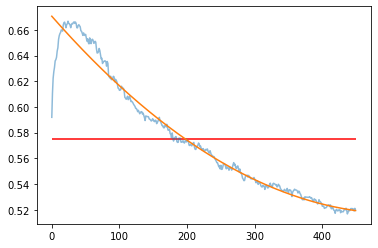

{0: [5.1e-05, 1, 24]}
0 1 0.6299315205106044 286 5.1e-06


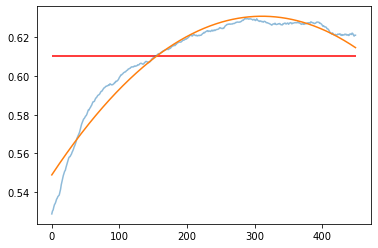

{0: [5.1e-05, 1, 24]}
0 2 0.6419785918489462 9 5.1e-05


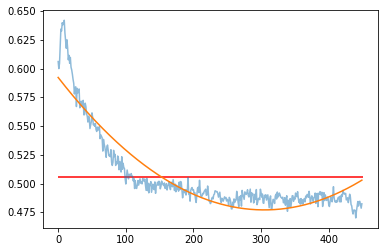

{0: [5.1e-05, 1, 24]}
0 2 0.6151452695964363 70 5.1e-06


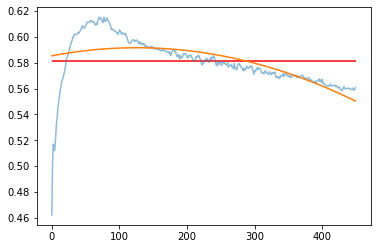

{0: [5.1e-05, 1, 24]}
0 5 0.6451033840835051 6 5.1e-05


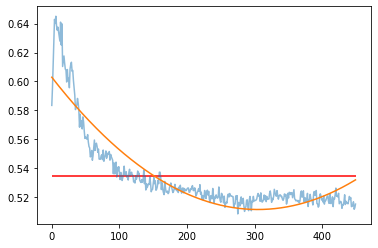

{0: [5.1e-05, 1, 24]}
0 5 0.6309420916162489 89 5.1e-06


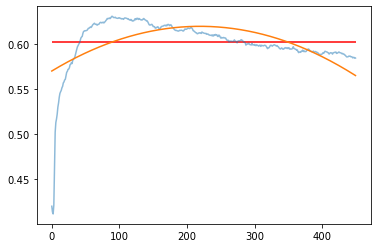

{0: [5.1e-05, 1, 24]}


C:\Users\Gebruiker\anaconda3\lib\site-packages\ipykernel_launcher.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


best UAC in cluster 2: 0.486 with model 1, f1: 0.168, lr 5.1e-05, epoch: 0
best UAC in cluster 2: 0.493 with model 1, f1: 0.176, lr 5.1e-05, epoch: 1
best UAC in cluster 2: 0.500 with model 1, f1: 0.175, lr 5.1e-05, epoch: 2
best UAC in cluster 2: 0.501 with model 1, f1: 0.178, lr 5.1e-05, epoch: 3
best UAC in cluster 2: 0.509 with model 1, f1: 0.186, lr 5.1e-05, epoch: 4
best UAC in cluster 2: 0.515 with model 1, f1: 0.192, lr 5.1e-05, epoch: 5
best UAC in cluster 2: 0.518 with model 1, f1: 0.196, lr 5.1e-05, epoch: 6
best UAC in cluster 2: 0.522 with model 1, f1: 0.200, lr 5.1e-05, epoch: 7
best UAC in cluster 2: 0.525 with model 1, f1: 0.197, lr 5.1e-05, epoch: 8
best UAC in cluster 2: 0.529 with model 1, f1: 0.199, lr 5.1e-05, epoch: 10
best UAC in cluster 2: 0.531 with model 1, f1: 0.196, lr 5.1e-05, epoch: 11
best UAC in cluster 2: 0.540 with model 1, f1: 0.197, lr 5.1e-05, epoch: 12
best UAC in cluster 2: 0.545 with model 1, f1: 0.205, lr 5.1e-05, epoch: 13
best UAC in cluster 2

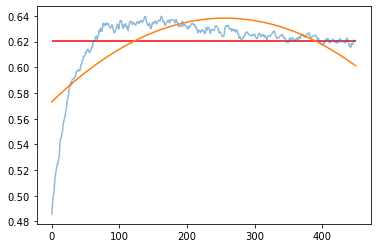

{0: [5.1e-05, 1, 24], 2: [5.1e-05, 1, 162]}
2 1 0.6326360944230333 447 5.1e-06


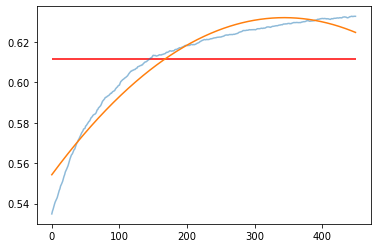

{0: [5.1e-05, 1, 24], 2: [5.1e-05, 1, 162]}
best UAC in cluster 2: 0.640 with model 2, f1: 0.250, lr 5.1e-05, epoch: 20
best UAC in cluster 2: 0.641 with model 2, f1: 0.239, lr 5.1e-05, epoch: 33
2 2 0.6405233365450012 33 5.1e-05


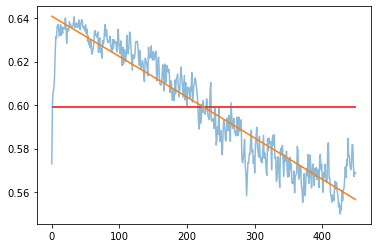

{0: [5.1e-05, 1, 24], 2: [5.1e-05, 2, 33]}
best UAC in cluster 2: 0.641 with model 2, f1: 0.250, lr 5.1e-06, epoch: 52
best UAC in cluster 2: 0.641 with model 2, f1: 0.250, lr 5.1e-06, epoch: 53
best UAC in cluster 2: 0.641 with model 2, f1: 0.251, lr 5.1e-06, epoch: 54
best UAC in cluster 2: 0.642 with model 2, f1: 0.254, lr 5.1e-06, epoch: 55
best UAC in cluster 2: 0.642 with model 2, f1: 0.253, lr 5.1e-06, epoch: 56
best UAC in cluster 2: 0.642 with model 2, f1: 0.251, lr 5.1e-06, epoch: 57
best UAC in cluster 2: 0.643 with model 2, f1: 0.251, lr 5.1e-06, epoch: 58
best UAC in cluster 2: 0.643 with model 2, f1: 0.251, lr 5.1e-06, epoch: 59
best UAC in cluster 2: 0.643 with model 2, f1: 0.253, lr 5.1e-06, epoch: 60
best UAC in cluster 2: 0.644 with model 2, f1: 0.251, lr 5.1e-06, epoch: 61
best UAC in cluster 2: 0.644 with model 2, f1: 0.251, lr 5.1e-06, epoch: 62
best UAC in cluster 2: 0.644 with model 2, f1: 0.253, lr 5.1e-06, epoch: 63
best UAC in cluster 2: 0.644 with model 2, f1

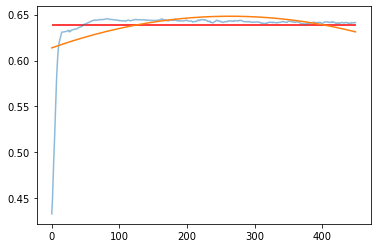

{0: [5.1e-05, 1, 24], 2: [5.1e-06, 2, 82]}
best UAC in cluster 2: 0.649 with model 5, f1: 0.253, lr 5.1e-05, epoch: 12
best UAC in cluster 2: 0.649 with model 5, f1: 0.253, lr 5.1e-05, epoch: 14
best UAC in cluster 2: 0.651 with model 5, f1: 0.251, lr 5.1e-05, epoch: 15
best UAC in cluster 2: 0.651 with model 5, f1: 0.250, lr 5.1e-05, epoch: 16
best UAC in cluster 2: 0.656 with model 5, f1: 0.253, lr 5.1e-05, epoch: 18
best UAC in cluster 2: 0.656 with model 5, f1: 0.253, lr 5.1e-05, epoch: 19
2 5 0.6564244573226027 19 5.1e-05


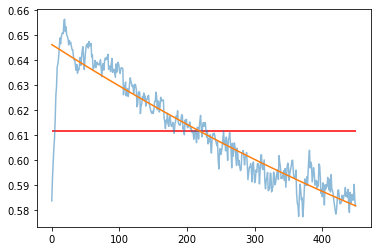

{0: [5.1e-05, 1, 24], 2: [5.1e-05, 5, 19]}
2 5 0.6360033864203128 339 5.1e-06


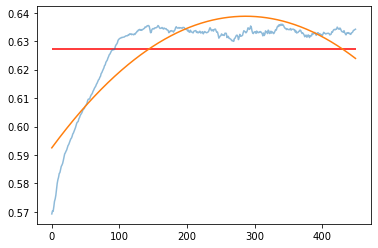

{0: [5.1e-05, 1, 24], 2: [5.1e-05, 5, 19]}


C:\Users\Gebruiker\anaconda3\lib\site-packages\ipykernel_launcher.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


best UAC in cluster 1: 0.568 with model 1, f1: 0.364, lr 5.1e-05, epoch: 0
best UAC in cluster 1: 0.575 with model 1, f1: 0.372, lr 5.1e-05, epoch: 1
best UAC in cluster 1: 0.583 with model 1, f1: 0.375, lr 5.1e-05, epoch: 2
best UAC in cluster 1: 0.591 with model 1, f1: 0.375, lr 5.1e-05, epoch: 3
best UAC in cluster 1: 0.594 with model 1, f1: 0.378, lr 5.1e-05, epoch: 4
best UAC in cluster 1: 0.600 with model 1, f1: 0.382, lr 5.1e-05, epoch: 5
best UAC in cluster 1: 0.606 with model 1, f1: 0.387, lr 5.1e-05, epoch: 6
best UAC in cluster 1: 0.609 with model 1, f1: 0.388, lr 5.1e-05, epoch: 7
best UAC in cluster 1: 0.613 with model 1, f1: 0.387, lr 5.1e-05, epoch: 10
best UAC in cluster 1: 0.620 with model 1, f1: 0.392, lr 5.1e-05, epoch: 11
best UAC in cluster 1: 0.620 with model 1, f1: 0.391, lr 5.1e-05, epoch: 12
best UAC in cluster 1: 0.622 with model 1, f1: 0.394, lr 5.1e-05, epoch: 13
best UAC in cluster 1: 0.624 with model 1, f1: 0.401, lr 5.1e-05, epoch: 15
best UAC in cluster 

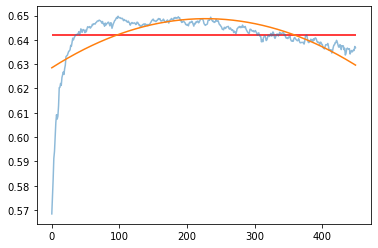

{0: [5.1e-05, 1, 24], 2: [5.1e-05, 5, 19], 1: [5.1e-05, 1, 98]}
1 1 0.6490844239155117 449 5.1e-06


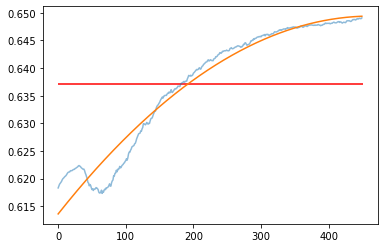

{0: [5.1e-05, 1, 24], 2: [5.1e-05, 5, 19], 1: [5.1e-05, 1, 98]}
1 2 0.6473973343108487 38 5.1e-05


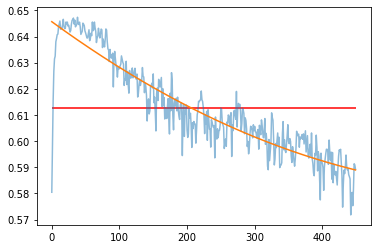

{0: [5.1e-05, 1, 24], 2: [5.1e-05, 5, 19], 1: [5.1e-05, 1, 98]}
best UAC in cluster 1: 0.650 with model 2, f1: 0.422, lr 5.1e-06, epoch: 181
best UAC in cluster 1: 0.650 with model 2, f1: 0.425, lr 5.1e-06, epoch: 183
best UAC in cluster 1: 0.650 with model 2, f1: 0.422, lr 5.1e-06, epoch: 184
best UAC in cluster 1: 0.650 with model 2, f1: 0.424, lr 5.1e-06, epoch: 185
best UAC in cluster 1: 0.650 with model 2, f1: 0.424, lr 5.1e-06, epoch: 186
best UAC in cluster 1: 0.650 with model 2, f1: 0.424, lr 5.1e-06, epoch: 187
best UAC in cluster 1: 0.650 with model 2, f1: 0.425, lr 5.1e-06, epoch: 188
best UAC in cluster 1: 0.651 with model 2, f1: 0.427, lr 5.1e-06, epoch: 189
best UAC in cluster 1: 0.651 with model 2, f1: 0.429, lr 5.1e-06, epoch: 202
best UAC in cluster 1: 0.651 with model 2, f1: 0.426, lr 5.1e-06, epoch: 203
best UAC in cluster 1: 0.651 with model 2, f1: 0.426, lr 5.1e-06, epoch: 206
best UAC in cluster 1: 0.651 with model 2, f1: 0.427, lr 5.1e-06, epoch: 220
best UAC in 

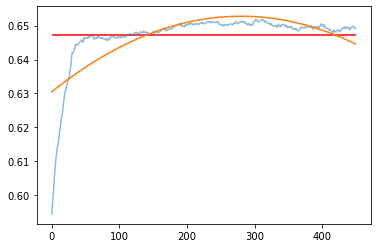

{0: [5.1e-05, 1, 24], 2: [5.1e-05, 5, 19], 1: [5.1e-06, 2, 311]}
1 5 0.6488883161694746 55 5.1e-05


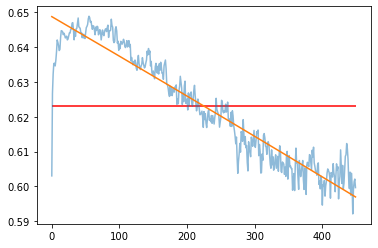

{0: [5.1e-05, 1, 24], 2: [5.1e-05, 5, 19], 1: [5.1e-06, 2, 311]}
best UAC in cluster 1: 0.652 with model 5, f1: 0.415, lr 5.1e-06, epoch: 69
best UAC in cluster 1: 0.652 with model 5, f1: 0.416, lr 5.1e-06, epoch: 70
best UAC in cluster 1: 0.652 with model 5, f1: 0.415, lr 5.1e-06, epoch: 72
best UAC in cluster 1: 0.653 with model 5, f1: 0.416, lr 5.1e-06, epoch: 77
best UAC in cluster 1: 0.653 with model 5, f1: 0.416, lr 5.1e-06, epoch: 84
best UAC in cluster 1: 0.653 with model 5, f1: 0.415, lr 5.1e-06, epoch: 90
best UAC in cluster 1: 0.653 with model 5, f1: 0.413, lr 5.1e-06, epoch: 91
best UAC in cluster 1: 0.653 with model 5, f1: 0.412, lr 5.1e-06, epoch: 92
best UAC in cluster 1: 0.653 with model 5, f1: 0.415, lr 5.1e-06, epoch: 93
best UAC in cluster 1: 0.653 with model 5, f1: 0.415, lr 5.1e-06, epoch: 94
best UAC in cluster 1: 0.653 with model 5, f1: 0.417, lr 5.1e-06, epoch: 99
best UAC in cluster 1: 0.653 with model 5, f1: 0.418, lr 5.1e-06, epoch: 100
best UAC in cluster 1:

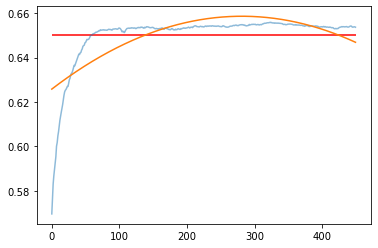

{0: [5.1e-05, 1, 24], 2: [5.1e-05, 5, 19], 1: [5.1e-06, 5, 323]}
auc!! 0.6315239608749625


In [24]:
n_epochs = 450
hists = train(models, X_train, Y_train, Y1_17, train_labels,
              X_val, Y_val, Y1_18, val_labels, n_epochs, 0.0000051)

In [25]:
hists

(0.6315239608749625,
 0.3153846153846154,
 {0: [5.1e-05, 1, 24], 2: [5.1e-05, 5, 19], 1: [5.1e-06, 5, 323]},
 {0: OrderedDict([('GRU.weight_ih_l0',
                tensor([[-0.0195,  0.1953,  0.2293,  ...,  0.0659, -0.2098,  0.1529],
                        [-0.0512,  0.0901,  0.1097,  ...,  0.0196, -0.0970, -0.1022],
                        [-0.0472, -0.0834, -0.1000,  ...,  0.0021,  0.0104,  0.0801],
                        ...,
                        [-0.0522,  0.2021, -0.0455,  ..., -0.1070, -0.0402, -0.0167],
                        [-0.0748, -0.0921, -0.1220,  ...,  0.1337,  0.0331,  0.0738],
                        [ 0.1309,  0.0727,  0.1599,  ..., -0.0825, -0.1888,  0.0722]])),
               ('GRU.weight_hh_l0',
                tensor([[ 0.2235,  0.0027,  0.1860,  ...,  0.1353, -0.2046,  0.1279],
                        [-0.0481, -0.2099, -0.0730,  ..., -0.0700, -0.2154, -0.1092],
                        [ 0.0431, -0.0164,  0.0552,  ..., -0.0498, -0.0054,  0.1186],
          

In [26]:
predictions = np.zeros(len(Y_test))
auc_clusters = {}
f1_clusters = {}

for clust in test_labels[0].unique():
  
    idxs = test_labels[test_labels[0] == clust].index
    xt = torch.tensor(X_test[idxs]).float().to(device)
    yt = Y_test[idxs]
    y1 = Y1_19[idxs]
    
    size = hists[2][clust][1]
    if size == 0: 
        model = RNN()
        model.load_state_dict(hists[3][clust])
        model.eval()
    elif size ==1: 
        model = RNN1()
        model.load_state_dict(hists[3][clust])
        model.eval()
    elif size == 2: 
        model = RNN2()
        model.load_state_dict(hists[3][clust])
        model.eval()
    elif size == 3: 
        model = RNN3()
        model.load_state_dict(hists[3][clust])
        model.eval()
    elif size == 4: 
        model = RNN4()
        model.load_state_dict(hists[3][clust])
        model.eval()
    else:
        model = RNN5()
        model.load_state_dict(hists[3][clust])
        model.eval()

    preds = model(xt, torch.tensor(y1).float())
    preds = preds.cpu().squeeze().detach().numpy()  
    auc = roc_auc_score(yt, preds)
    auc_clusters[clust] = auc

    Yhat = np.zeros(len(yt))
    pos_idxs = preds.argsort()[- (yt == 1).sum() : ]
    Yhat[pos_idxs] = 1
    f1_clusters[clust] = f1 = f1_score(yt, Yhat)

    predictions[idxs] = preds

pos_idxs = predictions.argsort()[- (Y_test == 1).sum() : ]
Yhat = np.zeros(len(Y_test))
Yhat[pos_idxs] = 1
auc = roc_auc_score(Y_test, predictions)
f1 = f1_score(Y_test, Yhat)
print(auc, f1)
name = "Nijmegen"
with open ("../Results/" + name +".csv", "a+") as f:
    f.write("\nRNN_cluster,{},{}".format(auc,f1))

    
with open ("../Results/" + name +"AUC.csv", "a+") as f:
    f.write("\nRNN_clust,{},{},{}".format(auc_clusters[0],auc_clusters[1],auc_clusters[2]))
    
with open ("../Results/" + name +"f1.csv", "a+") as f:
    f.write("\nRNN_clust,{},{},{}".format(f1_clusters[0],f1_clusters[1],f1_clusters[2]))
    
with open ("../Results/modellen.csv", "a") as f:
    f.write("\n" + name + ",RNNcluster," + str(hists[2]))
    

0.6055606893181764 0.33739837398373984


C:\Users\Gebruiker\anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
C:\Users\Gebruiker\anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
C:\Users\Gebruiker\anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


In [56]:
f1_clusters

{0: 0.17647058823529413, 2: 0.16666666666666666, 1: 0.26785714285714285}

In [27]:
auc_clusters

{0: 0.467721639656816, 2: 0.6275153866901565, 1: 0.6332507398595718}

In [29]:
hists[2]

{1: [5.1e-05, 5, 6], 0: [5.1e-06, 5, 39]}

In [45]:
hists[2][clust]

[5.1e-06, 5, 115]

best model: model 2, auc = 0.(0.7132703366008875,

f1: 0.3506410256410256,, lr =  5.1e-06

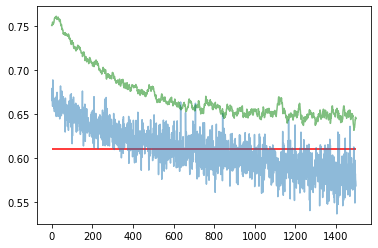

In [71]:
plt.plot(hists[-3], alpha = 0.5)
plt.hlines(np.mean(hists[-3]), 0, n_epochs, color = "r")
plt.plot(hists[-1], alpha = 0.5, color = "green")

0.6110970206754848 178


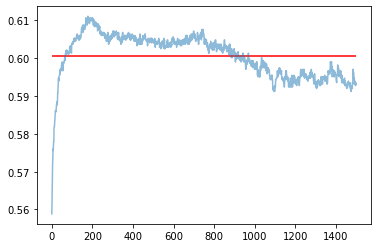

In [72]:
print(np.max(hists[-4]), np.argmax(hists[-4]))
plt.plot(hists[-4], alpha = 0.5)
plt.hlines(np.mean(hists[-4]), 0, n_epochs, color = "r")